In [1]:
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import sys

In [19]:
class VolData:
    def __init__(self, ticker, option_type='call', n=3):
        self.ticker = ticker
        self.option_type = option_type
        self.n = n

        """
        Initializing Class.
        Parameters
        ----------
        ticker: string 
            The stock ticker of interest        
        option_type: string
            The type of option that will be used to visualize the volatility smile ("call" or "put")
        n: integer
            "n" represents number of options above and below at-the-money (ATM).
             These options will be used to interpolate the ATM implied volatility term structure. 
             Assuming $1 strike differences, if n=3 and ATM=100, then the following strikes will
             be used for calculating the implied volatility term structure:
                 - lower ATM: 97, 98, 99
                 - upper ATM: 101, 102, 103
        
        Example
        ---------
        >>> import yahoo_vol as yvol
        >>> data = yvol.Options(ticker="AAPL", n=3)
        """
        

    def get_input_data(self, save_csv=False):
        """
        Intermediate function used to collect the pricing data for plotting purposes. 
        Parameter:
        ------------
        save_csv: boolean
            Select True to save the options data to a csv file
            
        Returns
        -------------
        dataframe:
            A dataframe with corresponding statistics for each option
        csv:
            A csv file will be saved if save_csv is set to True
        Example
        -------------
        >>> df = data.get_input_data(save_csv=True)
        """
        
        storage = []
        x = yf.Ticker(self.ticker)
        option_dates = x.options
        if len(option_dates) == 0:
            sys.exit("Ticker does not have any options. Please try another ticker")
        for date in tqdm(option_dates):
            try:
                call, put = x.option_chain(date)[0], x.option_chain(date)[1]
                call['option_type'], put['option_type'] = ('call', 'put')
                d = pd.concat([call, put])
                storage.append(d)
            except:
                pass
        print("All option dates successfully downloaded: ", len(storage) == len(option_dates))
        df = pd.concat(storage)
        df = df.reset_index()
        df['maturity'] = pd.DataFrame([i[-15:-9] for i in df.contractSymbol])
        return df

    def plot_vol_smile(self):
        """
        A plotting function used to visualize the volatility smile for each option maturity by plotting
        the raw implied volatility against the respective strike values. 
            
        Returns
        -------------
        plt.plot figure:
            A series of plots for each option maturity
        Example
        -------------
        >>> data.plot_vol_smile()
        """
        data = self.get_input_data()
        # Extract unique option maturity dates
        maturities = list(set(data.maturity))
        maturities.sort()
        # Loop through each maturity and plot the vol smile 
        for date in maturities:
            temp = data[(data.maturity == date) & (data.option_type == self.option_type)]
            title_date = datetime.date(2000 + int(date[:2]), int(date[2:4]), int(date[4:])).strftime("%B %d, %Y")
            plt.scatter(temp.strike, temp.impliedVolatility)
            plt.title(self.ticker.upper() + " " + self.option_type.upper() + ": " + title_date)
            plt.ylabel("Implied Volatility")
            plt.xlabel("Strike")
            plt.show()


    def plot_vol_term_structure(self):
        data = self.get_input_data()
        p = yf.Ticker(self.ticker).info
        mid_price = (p['ask'] + p['bid'])/2
        strikes = list(set(data.strike))
        maturities = list(set(data.maturity))

        get_closest_strike = min(range(len(strikes)), key=lambda i: abs(strikes[i]- mid_price))
        closest_ATM_indexes = list(range(get_closest_strike - self.n,
                                         get_closest_strike + self.n))
        closest_ATM_strikes = [strikes[i] for i in closest_ATM_indexes]
        storage = []
        for date in maturities:
            try: # NOTE - THE CALLS AND PUTS HERE ARE SEPERATED OUT - LOOK INTO HOW TO INCLUDE BOTH
                temp = data[(data.maturity == date) & (data.option_type== self.option_type)]
                storage.append(temp[temp['strike'].isin(closest_ATM_strikes)].mean()['impliedVolatility'])
            except:
                continue
        df = pd.DataFrame([maturities, storage]).T
        df = df.sort_values(0)
        df = df.dropna()
        plt.plot(df[0], df[1])
        plt.show()

In [22]:
x = VolData("AAPL", option_type='put')

In [27]:
import yahoo_vol as yv

In [30]:
x = yv.VolData("SPY")

In [32]:
df = x.get_input_data()

100%|██████████| 34/34 [00:09<00:00,  3.61it/s]


In [54]:
list(set(df.maturity))

['220318',
 '200529',
 '200624',
 '201231',
 '201218',
 '201120',
 '200630',
 '210331',
 '200702',
 '200629',
 '200918',
 '200617',
 '210618',
 '200608',
 '200930',
 '211217',
 '200615',
 '200821',
 '221216',
 '200612',
 '200605',
 '200610',
 '200717',
 '220121',
 '201201',
 '200626',
 '200622',
 '200603',
 '210917',
 '210115',
 '200619',
 '210319',
 '201016',
 '200601']

In [55]:
extract = df[(df.maturity == '221216') & (df.option_type == 'call')]

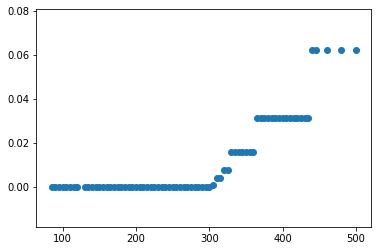

In [56]:
plt.scatter(extract.strike, extract.impliedVolatility)

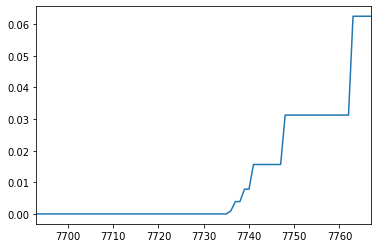

In [57]:
extract.impliedVolatility.plot()

In [53]:
# note yfinance sometimes messes up the IV cals for all options